# Installs & Imports

In [2]:
!pip install -q torch transformers datasets rouge nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 63.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 72.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [3]:
import torch
print(torch.__version__)

2.2.1+cu121


In [4]:
import numpy as np
import matplotlib.pyplot as plt

import os
import pickle
import random
import math
from tqdm.notebook import tqdm

import logging
from transformers import logging as transformers_logging

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler

from transformers import BartTokenizer, get_linear_schedule_with_warmup
import datasets
from datasets import load_dataset

from sklearn.model_selection import train_test_split

from rouge import Rouge

import nltk
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score

nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

torch.manual_seed(42)

transformers_logging.set_verbosity_error()

Using device: cuda


# Loading the Data

In [6]:
# Download and load the CNN/Daily Mail dataset
train_dataset = load_dataset("cnn_dailymail", "3.0.0", split="train")
val_dataset = load_dataset("cnn_dailymail", "3.0.0", split="validation")
test_dataset = load_dataset("cnn_dailymail", "3.0.0", split="test")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

In [7]:
# Get dataset information
def get_dataset_info(dataset):
    length = len(dataset)
    print(f"Dataset length: {length}")

    num_articles = len(dataset["article"])
    print(f"Number of articles: {num_articles}")

    num_highlights = len(dataset["highlights"])
    print(f"Number of highlights: {num_highlights}")

    dataset_type = type(dataset)
    print(f"Dataset type: {dataset_type}")

In [8]:
# Get basic dataset information
print("Train Dataset:")
get_dataset_info(train_dataset)

print("\nValidation Dataset:")
get_dataset_info(val_dataset)

print("\nTest Dataset:")
get_dataset_info(test_dataset)

Train Dataset:
Dataset length: 287113
Number of articles: 287113
Number of highlights: 287113
Dataset type: <class 'datasets.arrow_dataset.Dataset'>

Validation Dataset:
Dataset length: 13368
Number of articles: 13368
Number of highlights: 13368
Dataset type: <class 'datasets.arrow_dataset.Dataset'>

Test Dataset:
Dataset length: 11490
Number of articles: 11490
Number of highlights: 11490
Dataset type: <class 'datasets.arrow_dataset.Dataset'>


In [9]:
def examine_dataset(dataset, num_samples=5):
    for i in range(num_samples):
        sample = dataset[i]
        print(f"Article {i+1}: {sample['article']}\n")
        print(f"Highlights {i+1}: {sample['highlights']}\n")
        print("*" * 50)

In [10]:
# Examine dataset contents
print("Train Dataset:")
examine_dataset(train_dataset)

print("\nValidation Dataset:")
examine_dataset(val_dataset)

print("\nTest Dataset:")
examine_dataset(test_dataset)

Train Dataset:
Article 1: LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don't plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don't think I'll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box of

# Preprocessing the Data

In [11]:
# Load the BART tokenizer
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large")
#tokenizer = BartTokenizer.from_pretrained('sshleifer/distilbart-cnn-6-6')

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

In [12]:
def tokenize_function(example):
    # Tokenize the input text
    inputs = tokenizer(example['article'], truncation=True, padding='max_length', max_length=512)

    # Tokenize the target text
    labels = tokenizer(example['highlights'], truncation=True, padding='max_length', max_length=128)

    # Create decoder_input_ids
    decoder_input_ids = shift_right(labels['input_ids'], tokenizer.pad_token_id)

    inputs['labels'] = labels['input_ids']
    inputs['decoder_input_ids'] = decoder_input_ids

    return inputs

def shift_right(input_ids_list, pad_token_id):
    shifted_input_ids_list = []
    for input_ids in input_ids_list:
        shifted_input_ids = input_ids[:-1] + [pad_token_id]
        shifted_input_ids_list.append(shifted_input_ids)
    return shifted_input_ids_list

In [13]:
# Tokenize the datasets
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_val_dataset = val_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/287113 [00:00<?, ? examples/s]

Map:   0%|          | 0/13368 [00:00<?, ? examples/s]

Map:   0%|          | 0/11490 [00:00<?, ? examples/s]

In [14]:
# Examine tokenized datasets
print("Tokenized Train Dataset:")
print(tokenized_train_dataset[0])

print("\nTokenized Validation Dataset:")
print(tokenized_val_dataset[0])

print("\nTokenized Test Dataset:")
print(tokenized_test_dataset[0])

Tokenized Train Dataset:
{'article': 'LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won\'t cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don\'t plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don\'t think I\'ll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie 

In [15]:
# Set the format of the datasets
tokenized_train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels', 'decoder_input_ids'])
tokenized_val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels', 'decoder_input_ids'])
tokenized_test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels', 'decoder_input_ids'])

In [16]:
# Create subsets of the data
subset_size = 50000

train_subset = tokenized_train_dataset.select(range(subset_size))
val_subset = tokenized_val_dataset.select(range(subset_size // 5))
test_subset = tokenized_test_dataset.select(range(subset_size // 5))

In [17]:
# Create DataLoaders
batch_size = 32

train_dataloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_subset, batch_size=batch_size, drop_last=True)
test_dataloader = DataLoader(test_subset, batch_size=batch_size, drop_last=True)

In [18]:
# Examine the DataLoaders
print("Training Data Loader:")
batch_train = next(iter(train_dataloader))
for key in batch_train:
    print(f"{key}: {batch_train[key].shape}")
    print(batch_train[key])
print(f"Number of batches: {len(train_dataloader)}")
print(f"Number of samples: {len(train_dataloader) * batch_size}")

print("\nValidation Data Loader:")
batch_val = next(iter(val_dataloader))
for key in batch_val:
    print(f"{key}: {batch_val[key].shape}")
    print(batch_val[key])
print(f"Number of batches: {len(val_dataloader)}")
print(f"Number of samples: {len(val_dataloader) * batch_size}")

print("\nTest Data Loader:")
batch_test = next(iter(test_dataloader))
for key in batch_test:
    print(f"{key}: {batch_test[key].shape}")
    print(batch_test[key])
print(f"Number of batches: {len(test_dataloader)}")
print(f"Number of samples: {len(test_dataloader) * batch_size}")

Training Data Loader:
input_ids: torch.Size([32, 512])
tensor([[    0,  1640, 16256,  ...,     5,  4773,     2],
        [    0,  1640, 16256,  ...,     1,     1,     1],
        [    0,  4030,   469,  ...,  4466,   824,     2],
        ...,
        [    0,  1640, 16256,  ...,   881,   480,     2],
        [    0, 21631, 16641,  ...,     6,   114,     2],
        [    0,  1640, 16256,  ...,     1,     1,     1]])
attention_mask: torch.Size([32, 512])
tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]])
labels: torch.Size([32, 128])
tensor([[    0, 22117, 39029,  ...,     1,     1,     1],
        [    0,  8773,  1614,  ...,     1,     1,     1],
        [    0,   133,  3647,  ...,     1,     1,     1],
        ...,
        [    0, 14009,  2250,  ...,     1,     1,     1],
        [    0, 28421,  7445,  ...,     1,     1,   

# Creating the Model

In [19]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000, dropout=0.1):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [20]:
class ISTALayer(nn.Module):
    def __init__(self, in_features, out_features, dropout_rate=0.1):
        super(ISTALayer, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.threshold = nn.Parameter(torch.rand(1))
        self.norm = nn.LayerNorm(out_features)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        z = self.linear(x)
        z_norm = self.norm(z)
        z_threshold = torch.sign(z_norm) * F.gelu(torch.abs(z_norm) - self.threshold)
        return x + self.dropout(z_threshold)

In [90]:
class ISTATransformer(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, num_ista_layers, max_seq_length=5000, dropout_rate=0.1):
        super(ISTATransformer, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_seq_length, dropout_rate)
        self.dropout = nn.Dropout(dropout_rate)

        self.transformer_encoder = self._build_encoder(d_model, nhead, dim_feedforward, dropout_rate, num_encoder_layers)
        self.transformer_decoder = self._build_decoder(d_model, nhead, dim_feedforward, dropout_rate, num_decoder_layers)
        self.ista_layers = self._build_ista_layers(d_model, num_ista_layers, dropout_rate)
        self.output_layer = nn.Linear(d_model, vocab_size)

        self.init_weights()

    def _build_encoder(self, d_model, nhead, dim_feedforward, dropout_rate, num_layers):
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout=dropout_rate, activation='gelu', batch_first=True)
        return nn.TransformerEncoder(encoder_layer, num_layers)

    def _build_decoder(self, d_model, nhead, dim_feedforward, dropout_rate, num_layers):
        decoder_layer = nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout=dropout_rate, activation='gelu', batch_first=True)
        return nn.TransformerDecoder(decoder_layer, num_layers)

    def _build_ista_layers(self, d_model, num_layers, dropout_rate):
        return nn.ModuleList([ISTALayer(d_model, d_model, dropout_rate) for _ in range(num_layers)])

    def init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.Embedding):
                nn.init.normal_(module.weight, mean=0.0, std=0.02)
            elif isinstance(module, ISTALayer):
                nn.init.kaiming_normal_(module.linear.weight)
                nn.init.constant_(module.linear.bias, 0)
                module.threshold.data = torch.rand(1)

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float(-10000.0)).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, input_ids, attention_mask=None, decoder_input_ids=None):
        src = self.embedding(input_ids)
        src = self.pos_encoder(src)
        src = self.dropout(src)

        src_key_padding_mask = None
        if attention_mask is not None:
            src_key_padding_mask = (1.0 - attention_mask.float()) * -10000.0

        memory = self.transformer_encoder(src, src_key_padding_mask=src_key_padding_mask)

        if decoder_input_ids is not None:
            tgt = self.embedding(decoder_input_ids)
            tgt = self.pos_encoder(tgt)
            tgt = self.dropout(tgt)

            tgt_mask = self.generate_square_subsequent_mask(decoder_input_ids.size(1)).to(decoder_input_ids.device)
            tgt_key_padding_mask = (1.0 - decoder_input_ids.ne(tokenizer.pad_token_id).float()) * -10000.0

            output = self.transformer_decoder(tgt, memory, tgt_mask=tgt_mask, tgt_key_padding_mask=tgt_key_padding_mask)

            for layer in self.ista_layers:
                output = layer(output)
        else:
            output = memory

        logits = self.output_layer(output)
        return logits

In [72]:
# Define the model parameters
vocab_size = tokenizer.vocab_size
d_model = 512
nhead = 8
num_encoder_layers = 4
num_decoder_layers = 4
dim_feedforward = 1024
max_seq_length = 512
num_ista_layers = 3
dropout_rate = 0.2

In [73]:
# Initialize the model
model = ISTATransformer(
    vocab_size=vocab_size,
    d_model=d_model,
    nhead=nhead,
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    dim_feedforward=dim_feedforward,
    max_seq_length=max_seq_length,
    num_ista_layers=num_ista_layers,
    dropout_rate=dropout_rate
)
model.to(device)

ISTATransformer(
  (embedding): Embedding(50265, 512)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=1024, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=1024, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (transformer_decoder): TransformerDecoder(
    (layers): ModuleList(
      (0-3): 4 x Transforme

# Training the Model

In [74]:
def train_model(model, train_dataloader, val_dataloader, epochs, learning_rate, weight_decay, warmup_steps, device, patience=3, gradient_accumulation_steps=4, max_grad_norm=1.0):
    model.train()

    optimizer = optim.RAdam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    total_steps = len(train_dataloader) * epochs // gradient_accumulation_steps
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

    scaler = GradScaler()

    best_val_loss = float('inf')
    best_model_state_dict = None
    epochs_without_improvement = 0

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        train_loss = 0.0
        val_loss = 0.0

        model.train()
        train_progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1} - Training")
        for batch_idx, batch in enumerate(train_progress_bar):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            decoder_input_ids = batch['decoder_input_ids'].to(device)

            optimizer.zero_grad()

            with autocast():
                logits = model(input_ids, attention_mask=attention_mask, decoder_input_ids=decoder_input_ids)
                loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
                loss = loss_fn(logits.view(-1, logits.size(-1)), labels.view(-1)) / gradient_accumulation_steps

            scaler.scale(loss).backward()
            train_loss += loss.item()

            if (batch_idx + 1) % gradient_accumulation_steps == 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

                old_scaler = scaler.get_scale()
                scaler.step(optimizer)
                scaler.update()
                new_scaler = scaler.get_scale()

                if old_scaler <= new_scaler:
                    scheduler.step()

                optimizer.zero_grad()

            train_progress_bar.set_postfix({'loss': loss.item()})

            torch.cuda.empty_cache()

        model.eval()
        with torch.no_grad():
            val_progress_bar = tqdm(val_dataloader, desc=f"Epoch {epoch+1} - Validation")
            for batch in val_progress_bar:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                decoder_input_ids = batch['decoder_input_ids'].to(device)

                logits = model(input_ids, attention_mask=attention_mask, decoder_input_ids=decoder_input_ids)
                loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
                loss = loss_fn(logits.view(-1, logits.size(-1)), labels.view(-1))

                val_loss += loss.item()
                val_progress_bar.set_postfix({'loss': loss.item()})

                torch.cuda.empty_cache()

        train_loss /= len(train_dataloader)
        val_loss /= len(val_dataloader)

        tqdm.write(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state_dict = model.state_dict()
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            tqdm.write(f"Early stopping triggered at epoch {epoch+1}. Best validation loss: {best_val_loss:.4f}")
            break

        train_losses.append(train_loss)
        val_losses.append(val_loss)

    model.load_state_dict(best_model_state_dict)

    return model, train_losses, val_losses

In [75]:
# Set the training parameters
epochs = 30
learning_rate = 0.005
weight_decay = 0.05
warmup_steps = 1000
patience = 5
gradient_accumulation_steps = 4
max_grad_norm = 1.0

In [78]:
# Initialize the training loop
trained_model, train_losses, val_losses = train_model(
    model,
    train_dataloader,
    val_dataloader,
    epochs=epochs,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    warmup_steps=warmup_steps,
    device=device,
    patience=patience,
    gradient_accumulation_steps=gradient_accumulation_steps,
    max_grad_norm=max_grad_norm
)

Epoch 1 - Training:   0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 1 - Validation:   0%|          | 0/312 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:384: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:177.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)


Epoch 1/30 - Train Loss: 2.4014, Val Loss: 8.2402


Epoch 2 - Training:   0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 2 - Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 2/30 - Train Loss: 1.9994, Val Loss: 8.2214


Epoch 3 - Training:   0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 3 - Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 3/30 - Train Loss: 2.0171, Val Loss: 8.2516


Epoch 4 - Training:   0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 4 - Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 4/30 - Train Loss: 2.0226, Val Loss: 8.3260


Epoch 5 - Training:   0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 5 - Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 5/30 - Train Loss: 2.0279, Val Loss: 8.3235


Epoch 6 - Training:   0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 6 - Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 6/30 - Train Loss: 2.0339, Val Loss: 8.2656


Epoch 7 - Training:   0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 7 - Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 7/30 - Train Loss: 2.0018, Val Loss: 8.0589


Epoch 8 - Training:   0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 8 - Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 8/30 - Train Loss: 1.9947, Val Loss: 8.1008


Epoch 9 - Training:   0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 9 - Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 9/30 - Train Loss: 1.9918, Val Loss: 8.0413


Epoch 10 - Training:   0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 10 - Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 10/30 - Train Loss: 1.9900, Val Loss: 8.0199


Epoch 11 - Training:   0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 11 - Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 11/30 - Train Loss: 1.9898, Val Loss: 8.0428


Epoch 12 - Training:   0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 12 - Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 12/30 - Train Loss: 1.9886, Val Loss: 8.0429


Epoch 13 - Training:   0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 13 - Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 13/30 - Train Loss: 1.9888, Val Loss: 8.0255


Epoch 14 - Training:   0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 14 - Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 14/30 - Train Loss: 1.9881, Val Loss: 8.0071


Epoch 15 - Training:   0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 15 - Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 15/30 - Train Loss: 1.9878, Val Loss: 8.0121


Epoch 16 - Training:   0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 16 - Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 16/30 - Train Loss: 1.9867, Val Loss: 8.0246


Epoch 17 - Training:   0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 17 - Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 17/30 - Train Loss: 1.9864, Val Loss: 7.9985


Epoch 18 - Training:   0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 18 - Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 18/30 - Train Loss: 1.9860, Val Loss: 8.0112


Epoch 19 - Training:   0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 19 - Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 19/30 - Train Loss: 1.9849, Val Loss: 7.9969


Epoch 20 - Training:   0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 20 - Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 20/30 - Train Loss: 1.9839, Val Loss: 8.0054


Epoch 21 - Training:   0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 21 - Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 21/30 - Train Loss: 1.9831, Val Loss: 7.9880


Epoch 22 - Training:   0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 22 - Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 22/30 - Train Loss: 1.9821, Val Loss: 7.9930


Epoch 23 - Training:   0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 23 - Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 23/30 - Train Loss: 1.9811, Val Loss: 7.9835


Epoch 24 - Training:   0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 24 - Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 24/30 - Train Loss: 1.9801, Val Loss: 7.9834


Epoch 25 - Training:   0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 25 - Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 25/30 - Train Loss: 1.9789, Val Loss: 7.9841


Epoch 26 - Training:   0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 26 - Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 26/30 - Train Loss: 1.9778, Val Loss: 7.9800


Epoch 27 - Training:   0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 27 - Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 27/30 - Train Loss: 1.9769, Val Loss: 7.9650


Epoch 28 - Training:   0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 28 - Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 28/30 - Train Loss: 1.9757, Val Loss: 7.9658


Epoch 29 - Training:   0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 29 - Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 29/30 - Train Loss: 1.9724, Val Loss: 7.9555


Epoch 30 - Training:   0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 30 - Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 30/30 - Train Loss: 1.9693, Val Loss: 7.9572


In [79]:
def plot_losses(train_losses, val_losses):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot training and validation losses
    epochs = range(1, len(train_losses) + 1)
    ax.plot(epochs, train_losses, label='Training Loss', marker='o', linestyle='-', color='blue')
    ax.plot(epochs, val_losses, label='Validation Loss', marker='o', linestyle='-', color='orange')

    ax.set_title('Training and Validation Losses', fontsize=16, fontweight='bold')
    ax.set_xlabel('Epoch', fontsize=14)
    ax.set_ylabel('Loss', fontsize=14)

    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_xlim(0.5, len(train_losses) + 0.5)
    ax.set_ylim(0, max(max(train_losses), max(val_losses)) * 1.1)

    # Add annotations for minimum validation loss
    min_val_loss_epoch = val_losses.index(min(val_losses)) + 1
    min_val_loss = min(val_losses)
    ax.annotate(f'Min Val Loss: {min_val_loss:.4f}', xy=(min_val_loss_epoch, min_val_loss),
                xytext=(min_val_loss_epoch + 0.5, min_val_loss * 1.05),
                fontsize=12, color='red', arrowprops=dict(arrowstyle='->', color='red'))

    # Add annotations for training loss at the epoch with minimum validation loss
    train_loss_at_min_val_loss = train_losses[min_val_loss_epoch - 1]
    ax.annotate(f'Train Loss: {train_loss_at_min_val_loss:.4f}', xy=(min_val_loss_epoch, train_loss_at_min_val_loss),
                xytext=(min_val_loss_epoch, train_loss_at_min_val_loss * 1.2),
                textcoords='data', fontsize=12, color='red', arrowprops=dict(arrowstyle='->', color='red'))

    fig.suptitle('Model Training Progress', fontsize=18, fontweight='bold')
    plt.tight_layout(pad=2.0)
    plt.show()

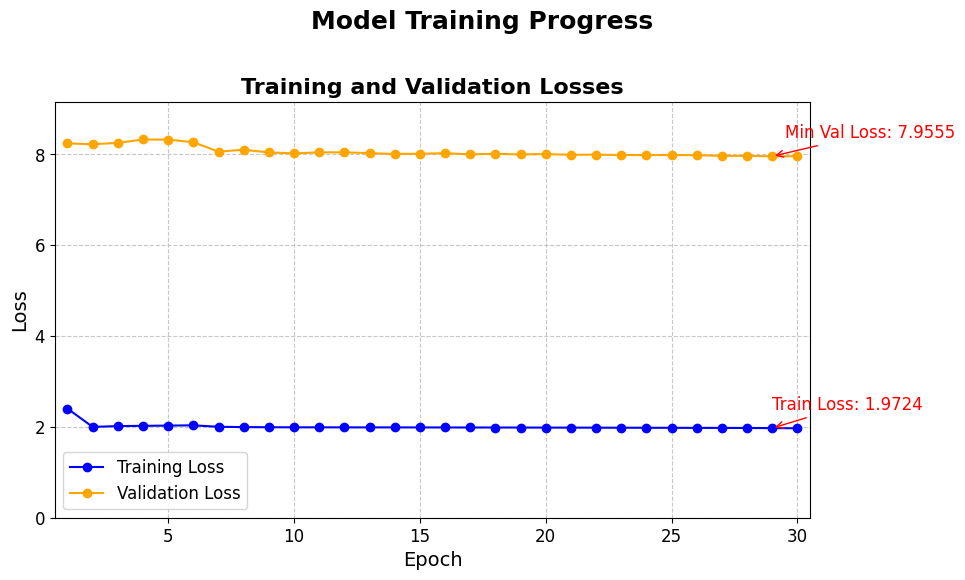

In [80]:
# Plot the losses
plot_losses(train_losses, val_losses)

# Evaluating the Model

In [81]:
def evaluate_loss(model, dataloader, tokenizer, device):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating Loss"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            decoder_input_ids = batch['decoder_input_ids'].to(device)

            logits = model(input_ids, attention_mask=attention_mask, decoder_input_ids=decoder_input_ids)
            loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
            loss = loss_fn(logits.view(-1, logits.size(-1)), labels.view(-1))

            total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Test Loss: {avg_loss:.4f}")
    return avg_loss

In [82]:
# Evaluate on the test set
evaluate_loss(trained_model, test_dataloader, tokenizer, device)

Evaluating Loss:   0%|          | 0/312 [00:00<?, ?it/s]

Test Loss: 7.9670


7.967032884940123

# Summary Generation

In [102]:
def beam_search_generate(model, tokenizer, input_text, device, beam_width=5, max_length=512):
    model.eval()

    # Tokenize and encode the input text
    input_ids = tokenizer.encode(input_text, return_tensors='pt', max_length=max_length, truncation=True).to(device)
    attention_mask = torch.ones(input_ids.shape, dtype=torch.long).to(device)

    initial_decoder_input_ids = torch.full((1, 1), tokenizer.bos_token_id, dtype=torch.long).to(device)
    beam_scores = torch.zeros(1).to(device)
    beams = [(initial_decoder_input_ids, beam_scores)]

    completed_beams = []

    with torch.no_grad():
        for step in range(max_length):
            new_beams = []
            for beam_input_ids, beam_score in beams:
                expanded_input_ids = input_ids.repeat(beam_input_ids.size(0), 1)
                expanded_attention_mask = attention_mask.repeat(beam_input_ids.size(0), 1)
                logits = model(expanded_input_ids, attention_mask=expanded_attention_mask, decoder_input_ids=beam_input_ids)

                if len(logits.shape) == 3:
                    logits = logits[:, -1, :]
                else:
                    logits = logits[:, :]

                log_probs = torch.nn.functional.log_softmax(logits, dim=-1)
                top_log_probs, top_indices = torch.topk(log_probs, beam_width)

                for i in range(beam_width):
                    next_token_id = top_indices[:, i].unsqueeze(-1)
                    new_score = beam_score + top_log_probs[:, i]
                    new_input_ids = torch.cat([beam_input_ids, next_token_id], dim=1)

                    if next_token_id.squeeze().item() == tokenizer.eos_token_id:
                        completed_beams.append((new_input_ids, new_score))
                    else:
                        new_beams.append((new_input_ids, new_score))

            # Keep top beam_width number of beams
            new_beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_width]
            beams = new_beams

            if len(completed_beams) >= beam_width:
                break

    # Choose the beam with the highest score
    completed_beams.extend(beams)
    completed_beams = sorted(completed_beams, key=lambda x: x[1], reverse=True)
    best_beam = completed_beams[0][0]
    decoded_sequence = tokenizer.decode(best_beam.squeeze(), skip_special_tokens=True)

    return decoded_sequence

In [100]:
# Define the text input
text = """Title: "SpaceX Successfully Launches Crew Dragon Spacecraft"

In a historic mission, SpaceX successfully launched its Crew Dragon spacecraft from NASA's Kennedy Space Center in Florida.
The launch marks a significant milestone in the company's efforts to provide commercial human spaceflight services.
The Crew Dragon, carrying NASA astronauts Bob Behnken and Doug Hurley, lifted off atop a Falcon 9 rocket and reached orbit flawlessly.
The spacecraft is now en route to the International Space Station (ISS), where it is expected to dock autonomously.
This mission, known as Demo-2, is the final test flight before NASA certifies SpaceX's Crew Dragon for regular crew flights to the ISS.
The success of this launch brings the United States one step closer to regaining its capability to launch astronauts from American soil,
a capability that was lost after the retirement of the Space Shuttle program in 2011.
SpaceX founder and CEO Elon Musk expressed his excitement and congratulated the teams involved in making this historic achievement possible.
The Crew Dragon is scheduled to return to Earth with the astronauts after a period of several weeks at the ISS.
"""

In [103]:
# Summarize text
summary = beam_search_generate(trained_model, tokenizer, text, device)
print("Generated summary:", summary)

Generated summary: ................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................


Model failure:
- The loss is high for training and validation
- Generated summaries are not valid

Directions for improvement:
- Re-design architecture entirely
- Unroll a different iterative algorithm
- Place the unrolled algorithm between encoder and decoder steps instead
- Refactor beam search function